 # Look at the rank of intermediate layers

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import numpy as np
import torch

from tqdm.notebook import tqdm
from functools import partial

from cpcn import *

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
seed = 123
torch.manual_seed(seed)

# get train, validation, and test loaders for MNIST
dataset = load_mnist(n_validation=1000, device=device)

 ## Try PCN without constraint

In [3]:
n_batches = 3000
dims = [784, 50, 10]
z_it = 70
z_lr = 0.1

torch.manual_seed(seed)

net = PCNetwork(
    dims, activation=lambda _: _, z_lr=z_lr, z_it=z_it, variances=1.0, bias=False,
)
net = net.to(device)

trainer = Trainer(net, dataset["train"], dataset["validation"])
trainer.peek_validation(every=10)
trainer.set_classifier("linear")

trainer.set_optimizer(torch.optim.SGD, lr=0.008)
# trainer.set_optimizer(torch.optim.Adam, lr=0.003)
# trainer.add_scheduler(partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.99))]

trainer.peek("weight", ["W"], every=10)
trainer.peek_sample("latent", ["z"])

trainer.peek_fast_dynamics("fast", ["z"], count=4)

results = trainer.run(n_batches=n_batches, progress=tqdm)

  0%|          | 0/3000 [00:00<?, ?it/s]

 ## Check convergence of PCN without constraint

Text(0.5, 0.98, 'PCN no constraint')

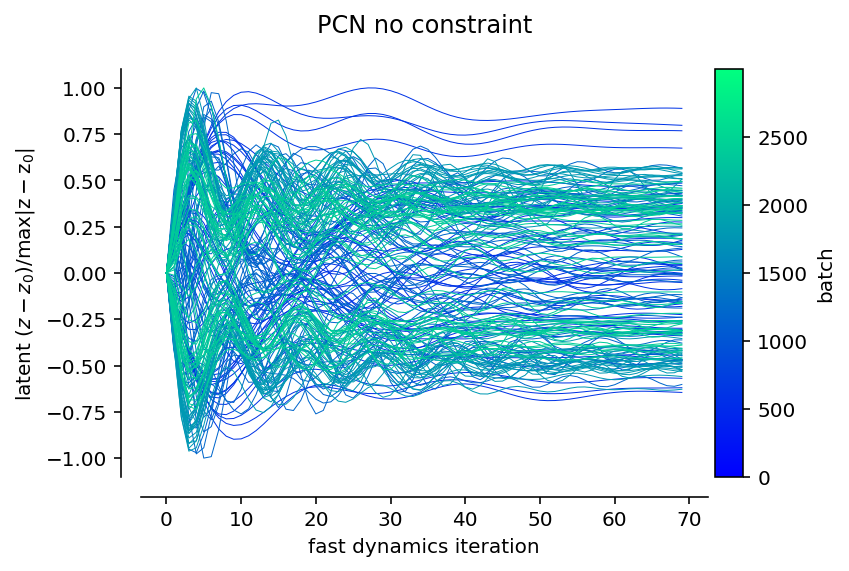

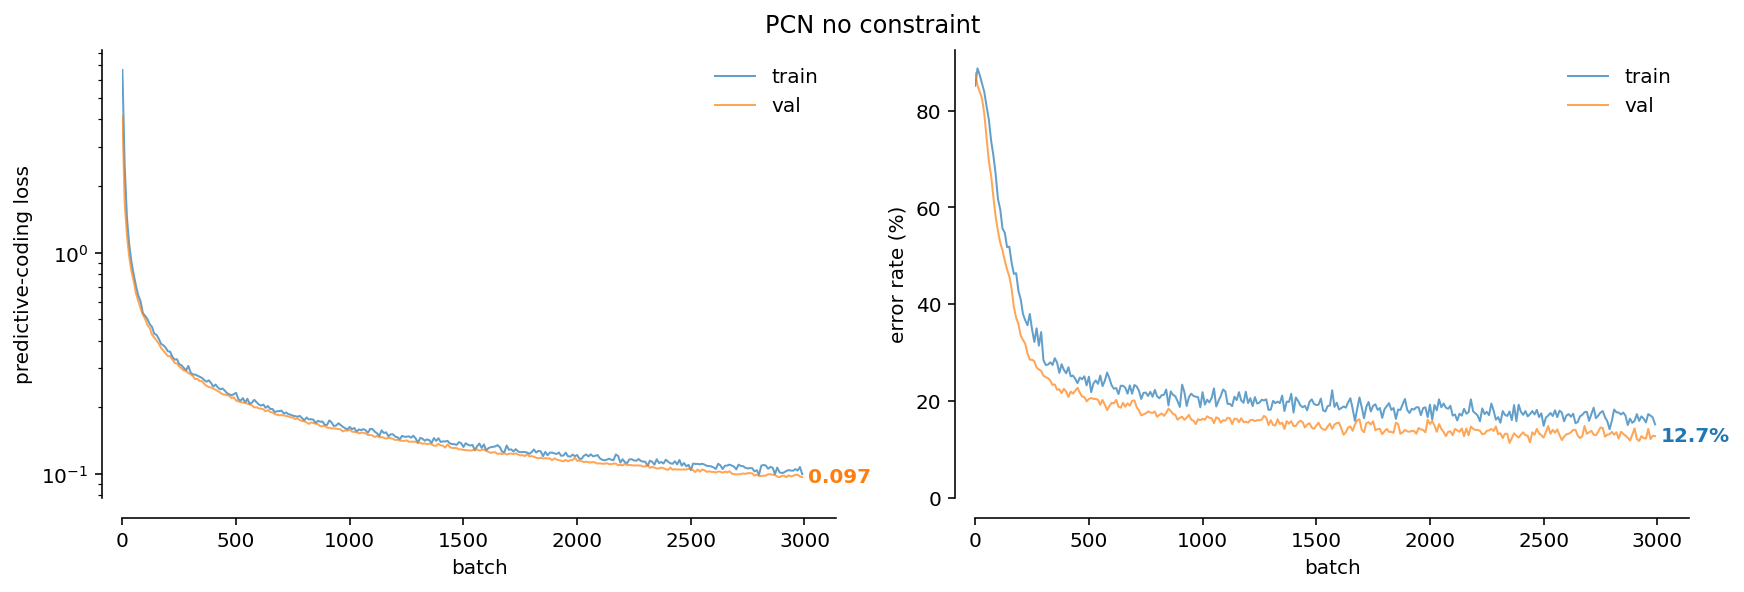

In [4]:
with dv.FigureManager() as (fig, ax):
    show_latent_convergence(results.fast)
    fig.suptitle("PCN no constraint")

fig = show_learning_curves(results)
fig.suptitle("PCN no constraint")

 ## Check whitening of PCN without constraint

approximate rank: 1


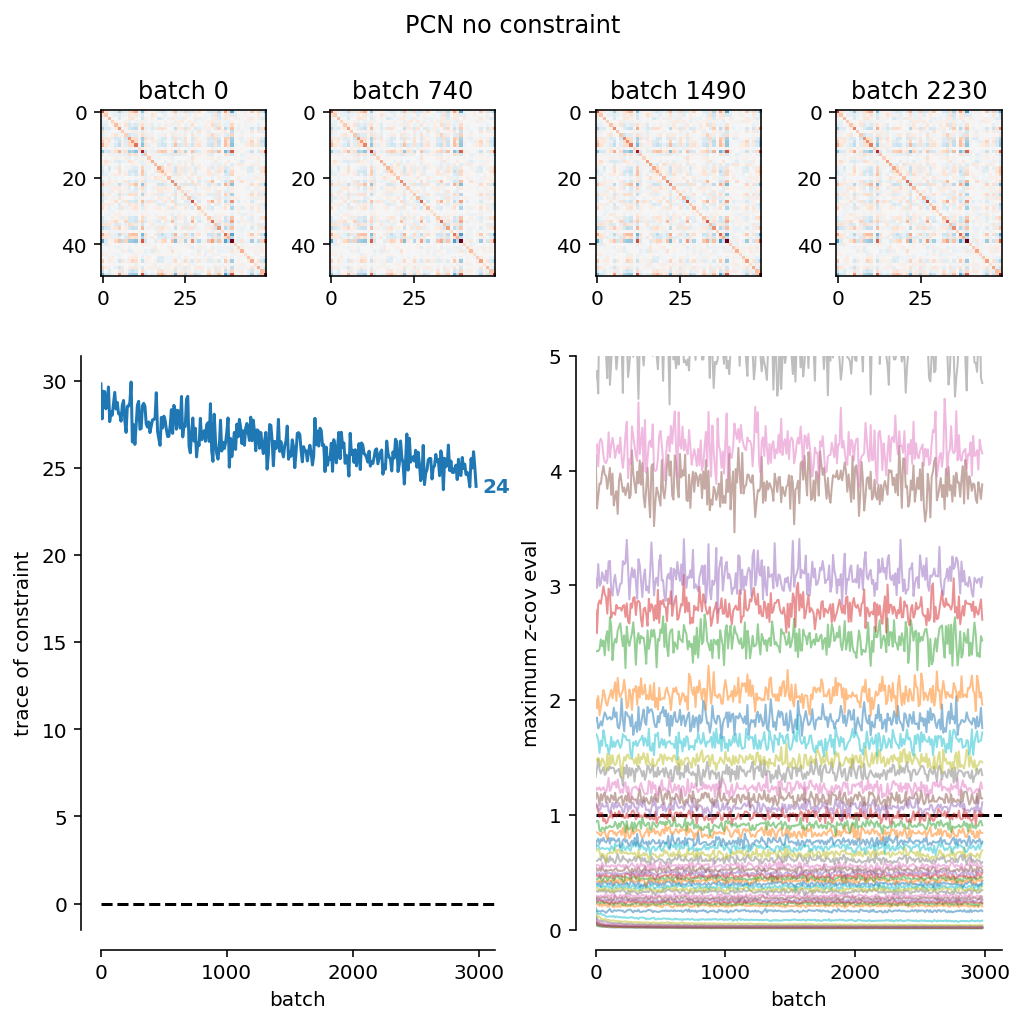

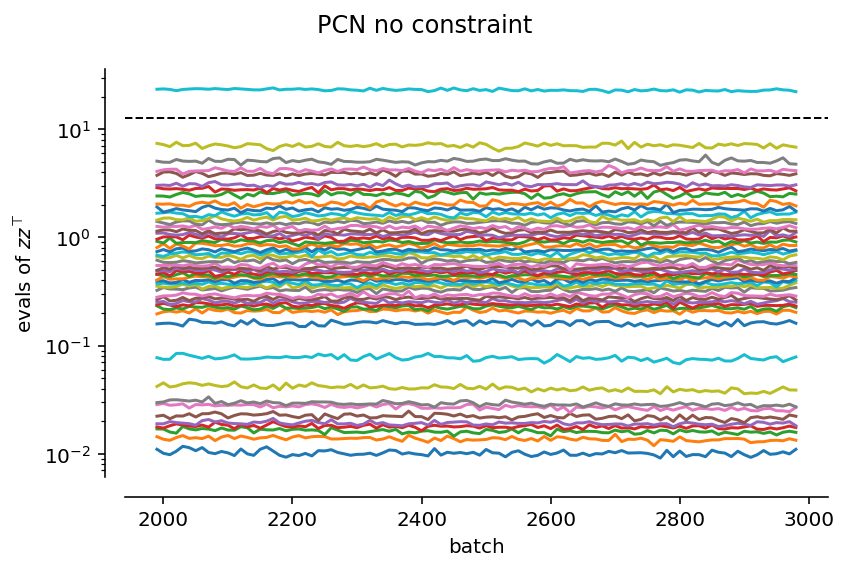

In [5]:
cons_diag = get_constraint_diagnostics(results.latent, rho=1.0)
fig = show_constraint_diagnostics(cons_diag, rho=1.0)
fig.suptitle("PCN no constraint")

crt_log_evals = np.mean(np.log10(cons_diag["evals:1"][-50:].numpy()), 0)
crt_log_dist = np.diff(crt_log_evals)
crt_idx = crt_log_dist.argmax()
crt_log_thresh = 0.5 * (crt_log_evals[crt_idx] + crt_log_evals[crt_idx + 1])
crt_thresh = 10 ** crt_log_thresh

with dv.FigureManager() as (fig, ax):
    ax.axhline(crt_thresh, c="k", ls="--", lw=1.0)
    ax.semilogy(cons_diag["batch"][-100:], cons_diag["evals:1"][-100:])
    ax.set_xlabel("batch")
    ax.set_ylabel("evals of $z z^\\top$")
    fig.suptitle("PCN no constraint")

print(f"approximate rank: {torch.sum(cons_diag['evals:1'][-1] > crt_thresh)}")

 ## What happens when we add a constraint?

In [6]:
torch.manual_seed(seed)
rho = 0.1
net_cons = PCNetwork(
    dims,
    activation=lambda _: _,
    z_lr=z_lr,
    z_it=z_it,
    variances=1.0,
    constrained=True,
    rho=rho,
    bias=False,
).to(device)

trainer_cons = Trainer(net_cons, dataset["train"], dataset["validation"])
trainer_cons.set_lr_factor("Q", 2)
trainer_cons.peek_validation(every=10)
trainer_cons.set_classifier("linear")

trainer_cons.set_optimizer(torch.optim.SGD, lr=0.008)
# trainer_cons.set_optimizer(torch.optim.Adam, lr=0.003)

trainer_cons.peek("weight", ["W", "Q"], every=10).peek_sample("latent", ["z"])
trainer_cons.peek_fast_dynamics("fast", ["z"], count=4)

results_cons = trainer_cons.run(n_batches=n_batches, progress=tqdm)

  0%|          | 0/3000 [00:00<?, ?it/s]

 ## Check convergence of PCN with constraint

Text(0.5, 0.98, 'PCN no constraint')

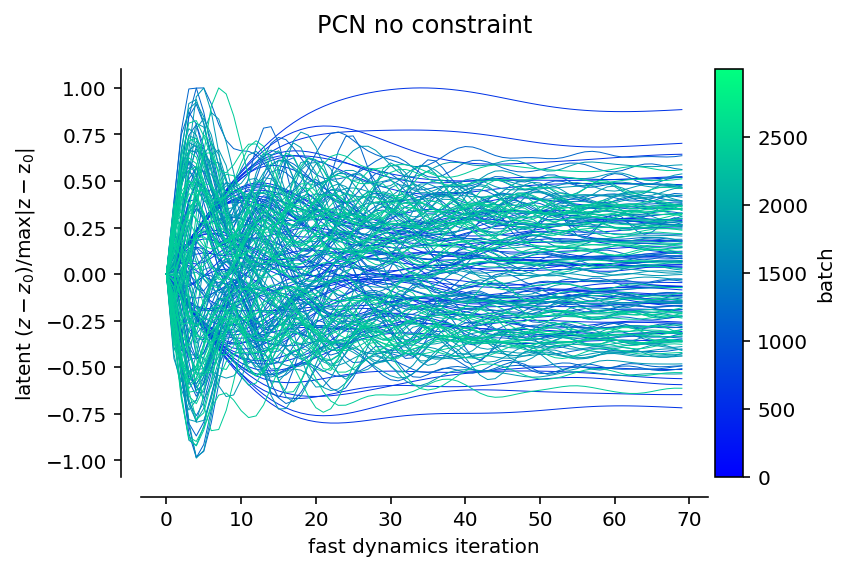

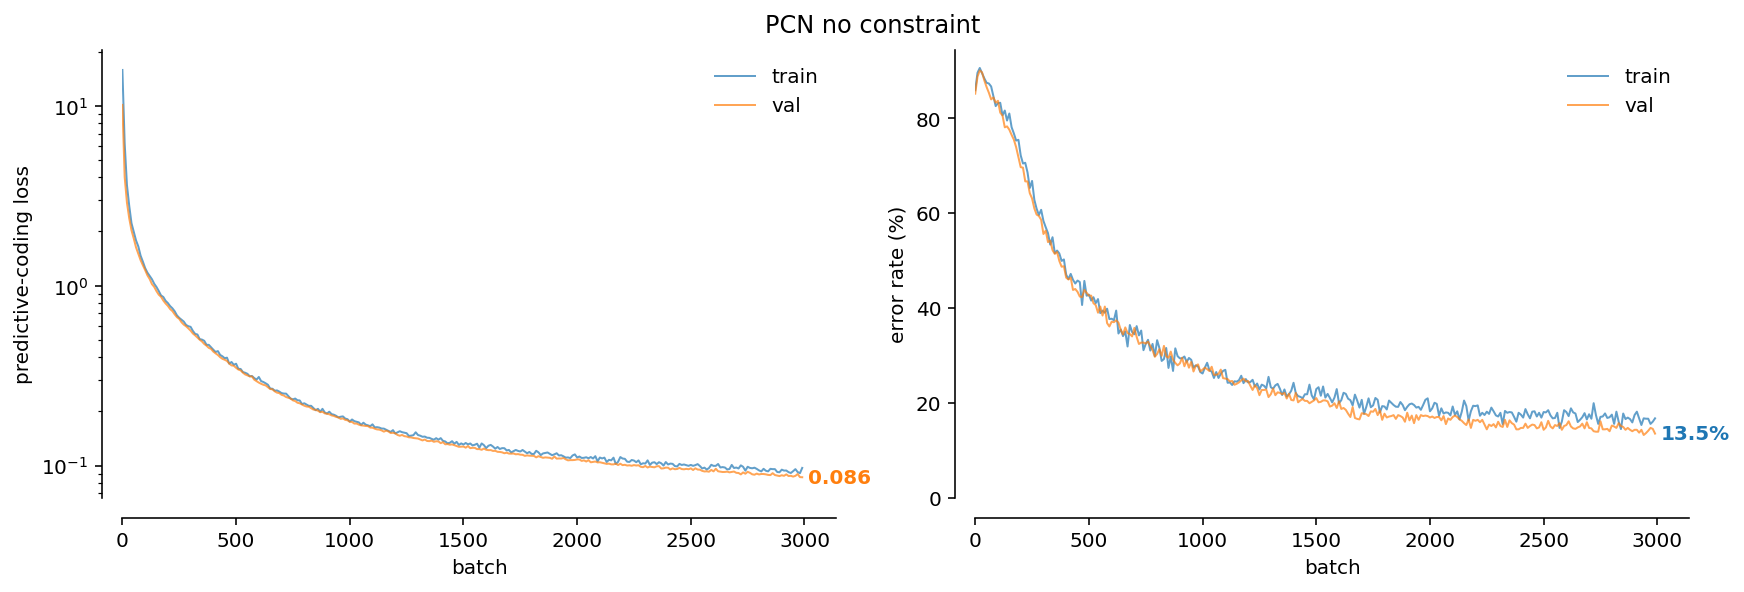

In [7]:
with dv.FigureManager() as (fig, ax):
    show_latent_convergence(results_cons.fast)
    fig.suptitle("PCN no constraint")

fig = show_learning_curves(results_cons)
fig.suptitle("PCN no constraint")

 ## Check whitening of PCN with constraint

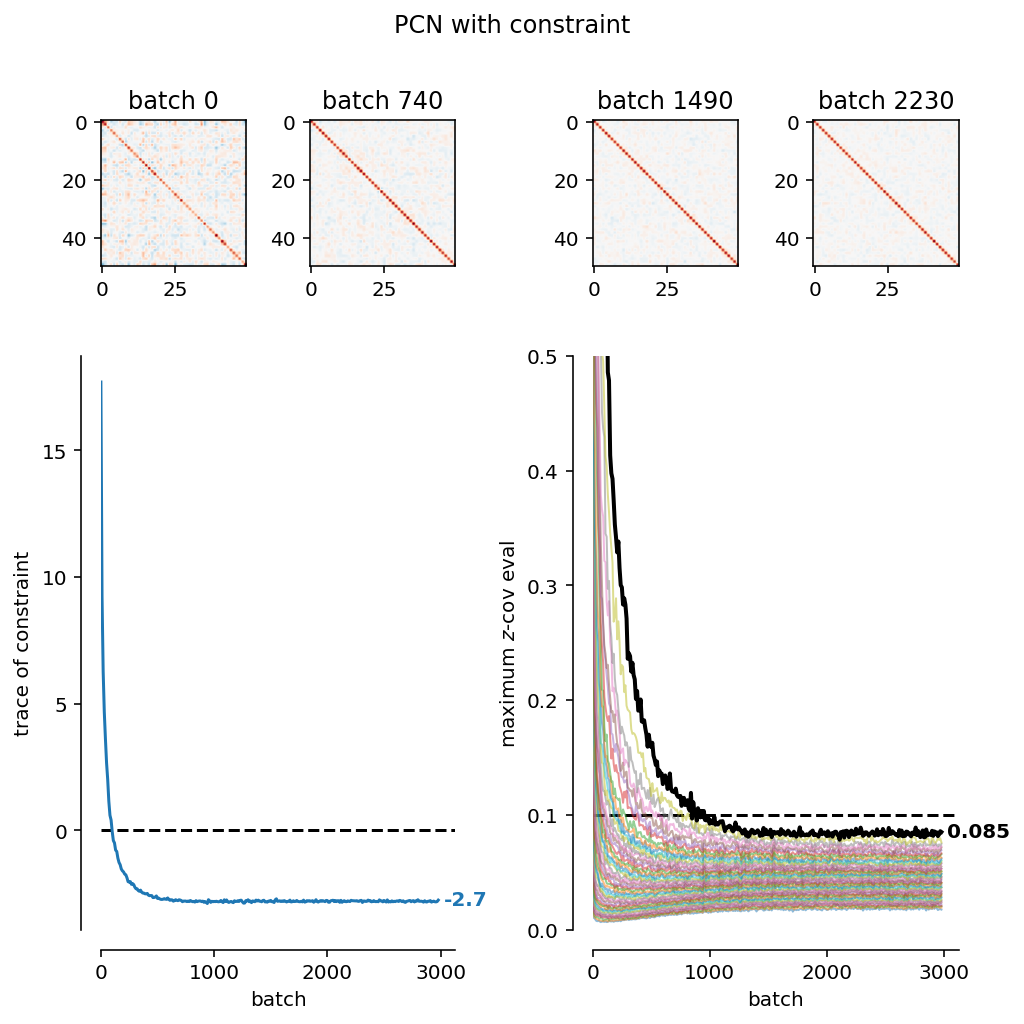

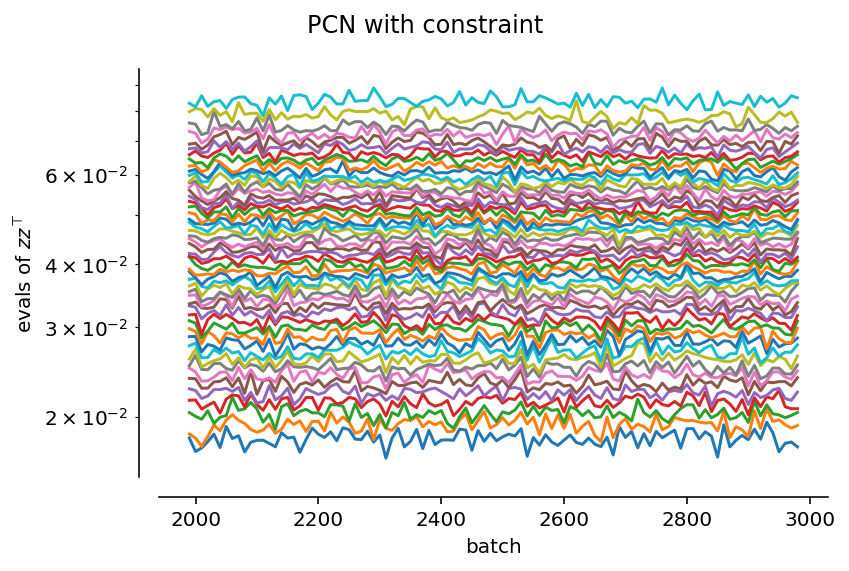

In [8]:
cons_diag_cons = get_constraint_diagnostics(results_cons.latent, rho=rho)
fig = show_constraint_diagnostics(cons_diag_cons, rho=rho)
fig.suptitle("PCN with constraint")

with dv.FigureManager() as (fig, ax):
    ax.semilogy(cons_diag_cons["batch"][-100:], cons_diag_cons["evals:1"][-100:])
    ax.set_xlabel("batch")
    ax.set_ylabel("evals of $z z^\\top$")
    fig.suptitle("PCN with constraint")

 ## Try CPCN

In [9]:
torch.manual_seed(seed)

cpcn = LinearBioPCN.from_pcn(net_cons).to(device)

trainer_cpcn = Trainer(cpcn, dataset["train"], dataset["validation"])
trainer_cpcn.set_lr_factor("Q", 0.5)
trainer_cpcn.peek_validation(every=10)
trainer_cpcn.set_classifier("linear")

trainer_cpcn.set_optimizer(torch.optim.SGD, lr=0.008)
# trainer_cpcn.set_optimizer(torch.optim.Adam, lr=0.003)
# trainer.add_scheduler(partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.99))]

trainer_cpcn.peek("weight", ["W_a", "W_b", "Q"], every=10).peek_sample("latent", ["z"])
trainer_cpcn.peek_fast_dynamics("fast", ["z"], count=4)

results_cpcn = trainer_cpcn.run(n_batches=n_batches, progress=tqdm)

  0%|          | 0/3000 [00:00<?, ?it/s]

 ## Check convergence of BioPCN

Text(0.5, 0.98, 'BioPCN')

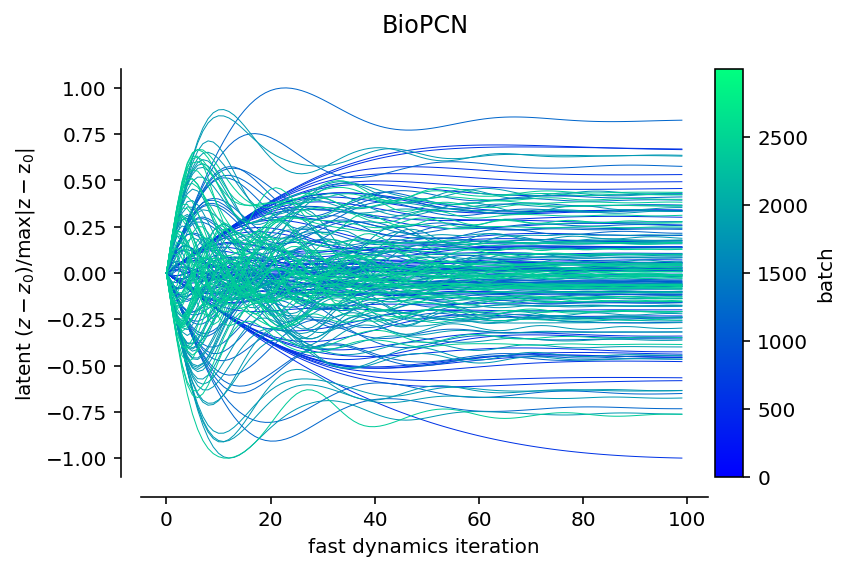

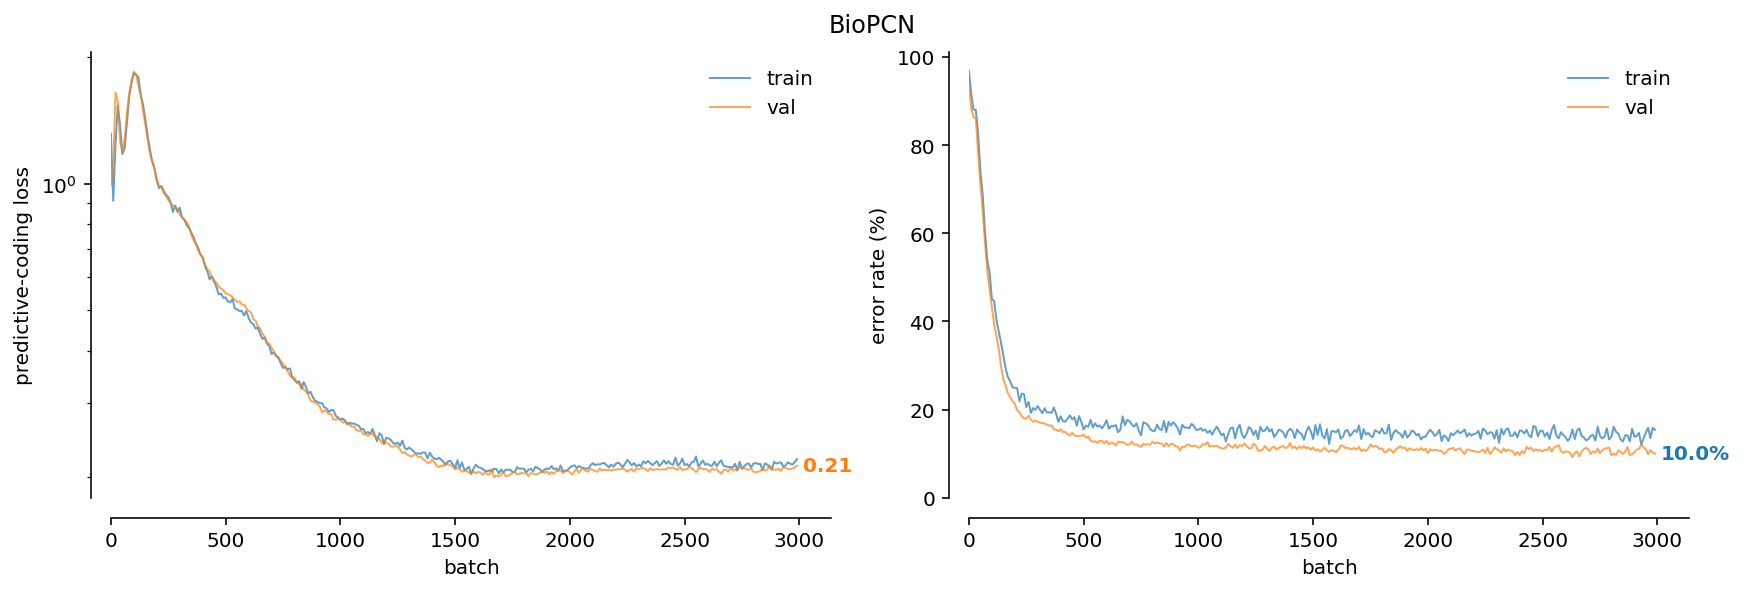

In [10]:
with dv.FigureManager() as (fig, ax):
    show_latent_convergence(results_cpcn.fast)
    fig.suptitle("BioPCN")

fig = show_learning_curves(results_cpcn)
fig.suptitle("BioPCN")

 ## Check whitening of BioPCN

approximate rank: 10


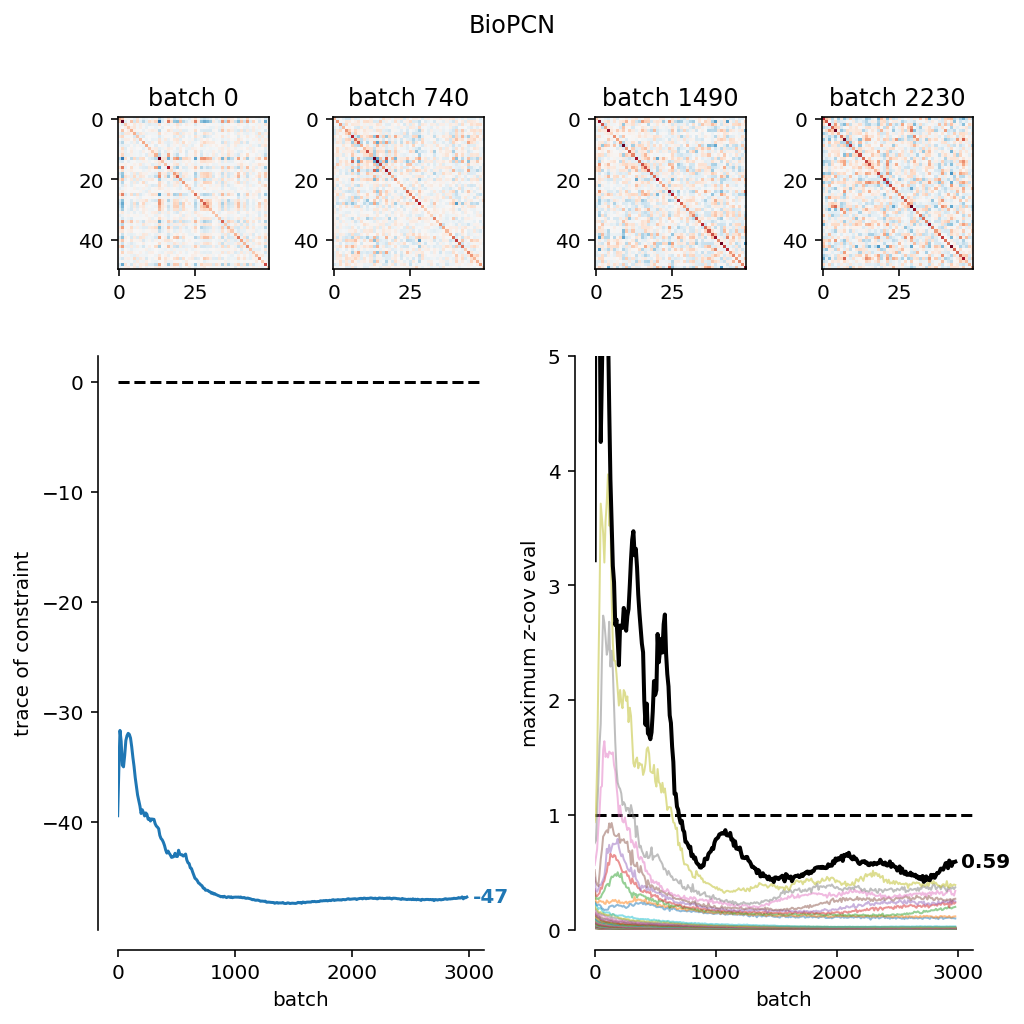

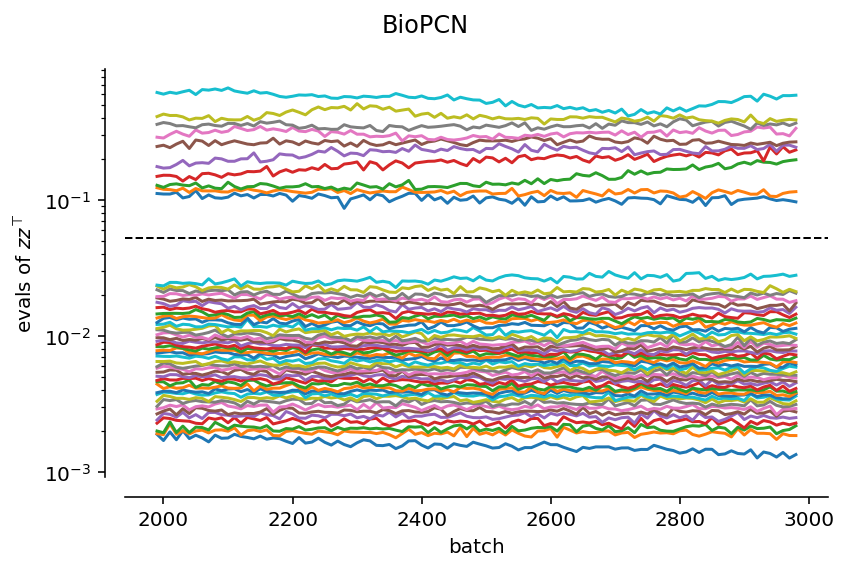

In [11]:
cons_diag_cpcn = get_constraint_diagnostics(results_cpcn.latent, rho=1.0)
fig = show_constraint_diagnostics(cons_diag_cpcn, rho=1.0)
fig.suptitle("BioPCN")

crt_log_evals = np.mean(np.log10(cons_diag_cpcn["evals:1"][-50:].numpy()), 0)
crt_log_dist = np.diff(crt_log_evals)
crt_idx = crt_log_dist.argmax()
crt_log_thresh = 0.5 * (crt_log_evals[crt_idx] + crt_log_evals[crt_idx + 1])
crt_thresh = 10 ** crt_log_thresh

with dv.FigureManager() as (fig, ax):
    ax.axhline(crt_thresh, c="k", ls="--", lw=1.0)
    ax.semilogy(cons_diag_cpcn["batch"][-100:], cons_diag_cpcn["evals:1"][-100:])
    ax.set_xlabel("batch")
    ax.set_ylabel("evals of $z z^\\top$")
    fig.suptitle("BioPCN")

print(f"approximate rank: {torch.sum(cons_diag_cpcn['evals:1'][-1] > crt_thresh)}")